In [ ]:
!pip install pydot
!pip install graphviz
!pip install opencv-python

In [1]:
#import all the required libraries
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
#from bs4 import BeautifulSoup

import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
tf.__version__

'2.15.0'

# Importing Dataset - cnn_dailymail

In [4]:
!pip install datasets

In [2]:
import datasets
train_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="train")
val_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="validation")
test_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="test")

In [3]:
train_data[0]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

# Data Visualization

## Creating DataFrames

In [4]:
df = pd.DataFrame()

df["text"] = train_data['article'][:1000]
df['summary'] = train_data['highlights'][:1000]

df.head()

,text,summary
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell...",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have be...
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a ja...","Mentally ill inmates in Miami are housed on the ""forgotten floor""\nJudge Steven Leifman says most are there as a result of ""avoidable felonies""\nWhile CNN tours facility, patient shouts: ""I am the..."
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. ""The whole bridge from one side of the Mississippi to the other just ...","NEW: ""I thought I was going to die,"" driver says .\nMan says pickup truck was folded in half; he just has cut on face .\nDriver: ""I probably had a 30-, 35-foot free fall""\nMinnesota bridge collaps..."
3,"WASHINGTON (CNN) -- Doctors removed five small polyps from President Bush's colon on Saturday, and ""none appeared worrisome,"" a White House spokesman said. The polyps were removed and sent to the ...","Five small polyps found during procedure; ""none worrisome,"" spokesman says .\nPresident reclaims powers transferred to vice president .\nBush undergoes routine colonoscopy at Camp David ."
4,"(CNN) -- The National Football League has indefinitely suspended Atlanta Falcons quarterback Michael Vick without pay, officials with the league said Friday. NFL star Michael Vick is set to appea...","NEW: NFL chief, Atlanta Falcons owner critical of Michael Vick's conduct .\nNFL suspends Falcons quarterback indefinitely without pay .\nVick admits funding dogfighting operation but says he did n..."


In [5]:
val = pd.DataFrame()

val["text"] = val_data['article'][:500]
val['summary'] = val_data['highlights'][:500]

val.head()
val.info

<bound method DataFrame.info of                                                                                                                                                                                                         text  \
0    (CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up ...   
1    (CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Ma...   
2    (CNN)French striker Bafetimbi Gomis, who has a history of fainting, said he is now "feeling well" after collapsing during Swansea's 3-2 loss at Tottenham in the Premier League on Wednesday. The wo...   
3    (CNN)It was an act of frustration perhaps more commonly associated with golf's fictional anti-hero Happy Gilmore than the world's r

In [6]:
test = pd.DataFrame()

test["text"] = test_data['article']
test['summary'] = test_data['highlights']

test.head()

,text,summary
0,"(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian terr...","Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .\nIsrael and the United States opposed the move, which could open the door to war cr..."
1,"(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguide...","Theia, a bully breed mix, was apparently hit by a car, whacked with a hammer and buried in a field .\n""She's a true miracle dog and she deserves a good life,"" says Sara Mellado, who is looking for..."
2,"(CNN)If you've been following the news lately, there are certain things you doubtless know about Mohammad Javad Zarif. He is, of course, the Iranian foreign minister. He has been U.S. Secretary of...",Mohammad Javad Zarif has spent more time with John Kerry than any other foreign minister .\nHe once participated in a takeover of the Iranian Consulate in San Francisco .\nThe Iranian foreign mini...
3,"(CNN)Five Americans who were monitored for three weeks at an Omaha, Nebraska, hospital after being exposed to Ebola in West Africa have been released, a Nebraska Medicine spokesman said in an emai...",17 Americans were exposed to the Ebola virus while in Sierra Leone in March .\nAnother person was diagnosed with the disease and taken to hospital in Maryland .\nNational Institutes of Health says...
4,"(CNN)A Duke student has admitted to hanging a noose made of rope from a tree near a student union, university officials said Thursday. The prestigious private school didn't identify the student, c...","Student is no longer on Duke University campus and will face disciplinary review .\nSchool officials identified student during investigation and the person admitted to hanging the noose, Duke says..."


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     1000 non-null   object
 1   summary  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [8]:
df['text'][:10]

0    LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell...
1    Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a ja...
2    MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. "The whole bridge from one side of the Mississippi to the other just ...
3    WASHINGTON (CNN) -- Doctors removed five small polyps from President Bush's colon on Saturday, and "none appeared worrisome," a White House spokesman said. The polyps were removed and sent to the ...
4    (CNN)  -- The National Football League has indefinitely suspended Atlanta Falcons quarterback Michael Vick without pay, officials with the league said Friday. NFL star Michael

In [9]:
df['summary'][:10]

0    Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have be...
1    Mentally ill inmates in Miami are housed on the "forgotten floor"\nJudge Steven Leifman says most are there as a result of "avoidable felonies"\nWhile CNN tours facility, patient shouts: "I am the...
2    NEW: "I thought I was going to die," driver says .\nMan says pickup truck was folded in half; he just has cut on face .\nDriver: "I probably had a 30-, 35-foot free fall"\nMinnesota bridge collaps...
3                Five small polyps found during procedure; "none worrisome," spokesman says .\nPresident reclaims powers transferred to vice president .\nBush undergoes routine colonoscopy at Camp David .
4    NEW: NFL chief, Atlanta Falcons owner critical of Michael Vick's conduct .\nNFL suspends Falcons quarterback indefinitely without pay .\nVick admits funding dogfighting operat

# Data Cleaning

In [10]:
#drop the duplicate and na values from the records

df.drop_duplicates(subset=['text'],inplace=True)
df.dropna(axis=0,inplace=True) #dropping na
input_data = df.loc[:,'text']
target_data = df.loc[:,'summary']
target_data.replace('', np.nan, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 959 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     959 non-null    object
 1   summary  959 non-null    object
dtypes: object(2)
memory usage: 22.5+ KB


In [12]:
# A list of contractions ~search "expanding english contractions in python" in StackOverflow.
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [13]:
import re
def clean_text(text, remove_stopwords = True):    
    # Convert words to lower case
    text = text.lower()    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', '', text)    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        #text = " ".join(text)
    return text

In [14]:
input_texts=[]  # Text column
target_texts=[] # summary column
input_words=[]
target_words=[]

In [15]:
#pass the input records and target records
for in_txt,tr_txt in zip(input_data,target_data):
  in_words= clean_text(in_txt,"inputs")
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  # 'sos' -> start of sentence , 'eos'-> end of sentence
  tr_words= clean_text("sos "+tr_txt+" eos","target")
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

In [16]:
input_words

['london',
 'england',
 'reuters',
 'harry',
 'potter',
 'star',
 'daniel',
 'radcliffe',
 'gains',
 'access',
 'reported',
 '£20',
 'million',
 '41',
 '1',
 'million',
 'fortune',
 'turns',
 '18',
 'monday',
 'insists',
 'money',
 'cast',
 'spell',
 'daniel',
 'radcliffe',
 'harry',
 'potter',
 'harry',
 'potter',
 'order',
 'phoenix',
 'disappointment',
 'gossip',
 'columnists',
 'around',
 'world',
 'young',
 'actor',
 'says',
 'plans',
 'fritter',
 'cash',
 'away',
 'fast',
 'cars',
 'drink',
 'celebrity',
 'parties',
 'plan',
 'one',
 'people',
 'soon',
 'turn',
 '18',
 'suddenly',
 'buy',
 'massive',
 'sports',
 'car',
 'collection',
 'something',
 'similar',
 'told',
 'australian',
 'interviewer',
 'earlier',
 'month',
 'think',
 'particularly',
 'extravagant',
 'things',
 'like',
 'buying',
 'things',
 'cost',
 '10',
 'pounds',
 'books',
 'cds',
 'dvds',
 '18',
 'radcliffe',
 'able',
 'gamble',
 'casino',
 'buy',
 'drink',
 'pub',
 'see',
 'horror',
 'film',
 'hostel',
 'part',

In [17]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_in_words = len(input_words) #total number of input words
num_tr_words = len(target_words) #total number of target words
 
#get the length of the input and target texts which appears most often  
max_in_len = mode([len(i) for i in input_texts])
max_tr_len = mode([len(i) for i in target_texts])
 
print("number of input words : ",num_in_words)
print("number of target words : ",num_tr_words)
print("maximum input length : ",max_in_len)
print("maximum target length : ",max_tr_len)

number of input words :  28942
number of target words :  8223
maximum input length :  3090
maximum target length :  173


In [18]:
input_texts[3],target_texts[3]

('washington cnn doctors removed five small polyps president bushs colon saturday none appeared worrisome white house spokesman said polyps removed sent national naval medical center bethesda maryland routine microscopic examination spokesman scott stanzel said results expected two three days small less centimeter half inch diameter said bush good humor stanzel said resume activities camp david procedure vice president dick cheney assumed presidential power bush reclaimed presidential power 9 21 two hours doctors used monitored anesthesia care stanzel said president asleep deeply unconscious true general anesthetic spoke first lady laura bush midland texas celebrating mothers birthday procedure stanzel said afterward president played scottish terriers barney miss beazley stanzel said planned lunch camp david briefings national security adviser stephen hadley white house chief staff josh bolten planned take bicycle ride saturday afternoon cheney meanwhile spent morning home marylands ea

In [19]:
#split the input and target text into 80:20 ratio or testing size of 20%.
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=42) 

In [20]:
#train the tokenizer with all the words
in_tokenizer = Tokenizer()
in_tokenizer.fit_on_texts(x_train)
tr_tokenizer = Tokenizer()
tr_tokenizer.fit_on_texts(y_train)
 
#convert text into sequence of integers
#where the integer will be the index of that word
x_train= in_tokenizer.texts_to_sequences(x_train) 
y_train= tr_tokenizer.texts_to_sequences(y_train)

In [21]:
#pad array of 0's if the length is less than the maximum length 
en_in_data= pad_sequences(x_train,  maxlen=max_in_len, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_tr_len, padding='post')

#decoder input data will not include the last word i.e. 'eos' in decoder input data
dec_in_data = dec_data[:,:-1]
#decoder target data will be one time step ahead as it will not include
# the first word i.e 'sos'
dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

# Model Building

In [22]:
latent_dim = 250
 
#create input object of total number of encoder words
en_inputs = Input(shape=(max_in_len,)) 
en_embedding = Embedding(num_in_words+1, latent_dim)(en_inputs) 

In [23]:
en_embedding

<KerasTensor: shape=(None, 3090, 250) dtype=float32 (created by layer 'embedding')>

In [24]:
#encoder
#create 3 stacked LSTM layer with the shape of hidden dimension for text summarizer using deep learning
#LSTM 1
en_lstm1= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(latent_dim, return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(latent_dim,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#encoder states
en_states= [state_h3, state_c3]

# Decoder. 
dec_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_in_words+1, latent_dim) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#initialize decoder's LSTM layer with the output states of encoder
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

#Attention layer
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

#Dense layer (output layer)
dec_dense = Dense(num_in_words+1, activation='softmax') 
dec_outputs = dec_dense(merge)

In [25]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3090)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 3090, 250)            7235750   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 3090, 250),          501000    ['embedding[0][0]']           
                              (None, 250),                                                        
                              (None, 250)]                                                        
                                                                                              

In [26]:
from tensorflow.keras.utils import plot_model

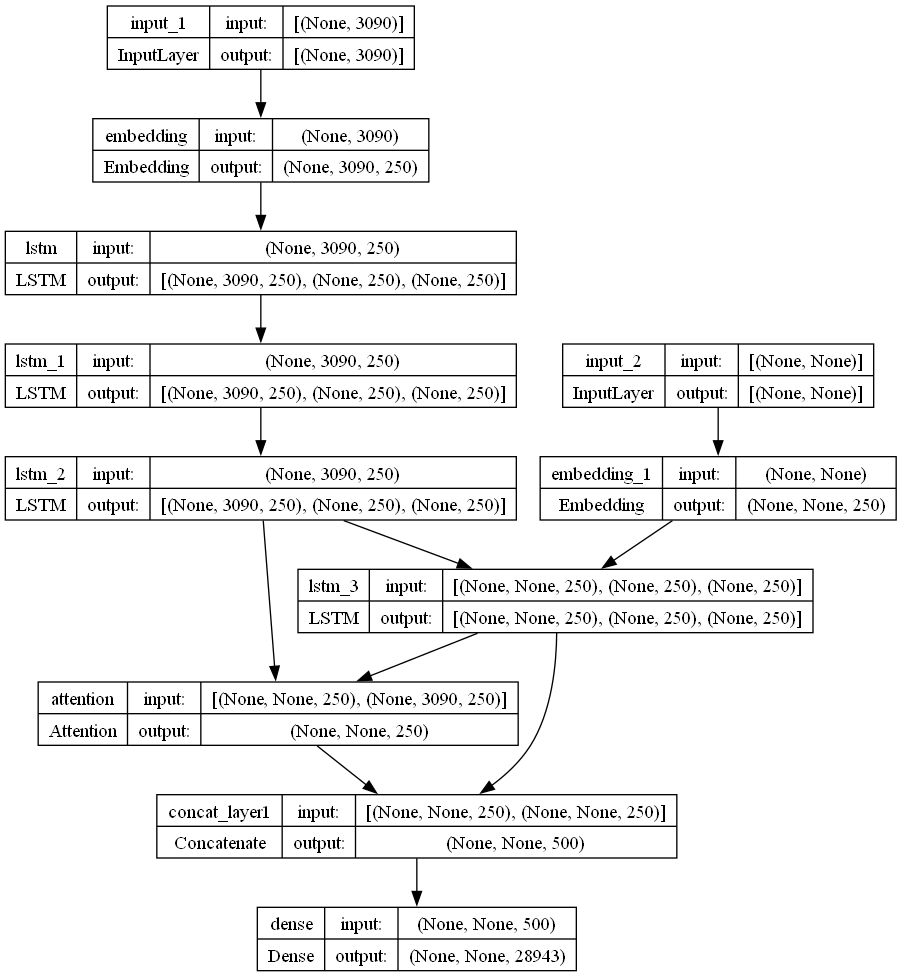

In [27]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [140]:
model.compile(optimizer = "rmsprop",loss="sparse_categorical_crossentropy", metrics=["accuracy"], )

In [141]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

In [142]:
history = model.fit([en_in_data, dec_in_data],dec_tr_data,batch_size=5,epochs=2,validation_split=0.2,verbose=1)

Epoch 1/2
123/123 [==============================] - 1112s 9s/step - loss: 2.0361 - accuracy: 0.8221 - val_loss: 1.5202 - val_accuracy: 0.8320
Epoch 2/2
123/123 [==============================] - 1070s 9s/step - loss: 1.4867 - accuracy: 0.8340 - val_loss: 1.4897 - val_accuracy: 0.8377


In [143]:
# save model
model.save('text_summarizer.h5')
print('Model Saved!')

Model Saved!


In [144]:
import joblib

joblib.dump(in_tokenizer,'text_tokenizer.pkl')
joblib.dump(tr_tokenizer,'summary_tokenizer.pkl')

['summary_tokenizer.pkl']

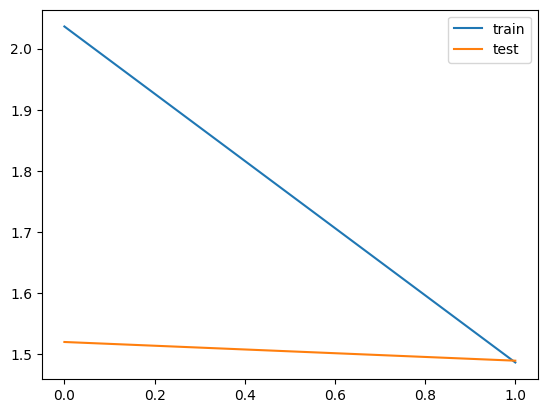

In [145]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [76]:
history.history

{'loss': [0.11502010375261307,
  0.08267617970705032,
  0.09478013217449188,
  0.08409368246793747,
  0.07525913417339325,
  0.07953823357820511,
  0.07989970594644547,
  0.07699514180421829,
  0.077499620616436,
  0.07749653607606888],
 'accuracy': [0.8666318655014038,
  0.8701267838478088,
  0.8703023791313171,
  0.8706714510917664,
  0.870755136013031,
  0.8704848885536194,
  0.8707537651062012,
  0.8707983493804932,
  0.8707983493804932,
  0.8707764148712158],
 'val_loss': [0.08059963583946228,
  0.08077021688222885,
  0.09766695648431778,
  0.0751028060913086,
  0.07508780062198639,
  0.07765575498342514,
  0.07918591797351837,
  0.0761309415102005,
  0.07755613327026367,
  0.075434111058712],
 'val_accuracy': [0.8714368939399719,
  0.8714341521263123,
  0.8711598515510559,
  0.872218668460846,
  0.872218668460846,
  0.8719663023948669,
  0.8721857070922852,
  0.8722131848335266,
  0.8722159266471863,
  0.8722159266471863]}

In [146]:
results = model.evaluate([en_in_data, dec_in_data],dec_tr_data)
print("test loss, test acc:", results)

24/24 [==============================] - 274s 11s/step - loss: 1.4382 - accuracy: 0.8364
test loss, test acc: [1.43819260597229, 0.8364209532737732]


# Inference

In [28]:
import joblib

# seq2seq model
model = models.load_model("text_summarizer.h5")
# text tokenizer
in_tokenizer = joblib.load('text_tokenizer.pkl')
# summary tokenizer
tr_tokenizer = joblib.load('summary_tokenizer.pkl')

In [30]:
history = model.fit([en_in_data, dec_in_data],dec_tr_data,batch_size=5,epochs=1,validation_split=0.2,verbose=1)


123/123 [==============================] - 663s 5s/step - loss: 1.4515 - accuracy: 0.8360 - val_loss: 1.4953 - val_accuracy: 0.8371


In [29]:
# encoder inference
latent_dim=250
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(latent_dim,))
dec_state_input_c = Input(shape=(latent_dim,))
dec_hidden_state_input = Input(shape=(max_in_len,latent_dim))
 
# Get the embeddings and input layer from the model
dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
dec_lstm = model.layers[7]
dec_embedding= dec_emb_layer(dec_inputs)
 
#add input and initialize LSTM layer with encoder LSTM states.
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

#Attention layer
attention = model.layers[8]
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])
 
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

#Dense layer
dec_dense = model.layers[10]
dec_outputs2 = dec_dense(merge2)
 
# Finally define the Model Class
dec_model = Model([dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],[dec_outputs2] + [state_h2, state_c2])

In [30]:
#create a dictionary with a key as index and value as words.
reverse_target_word_index = tr_tokenizer.index_word
reverse_source_word_index = in_tokenizer.index_word
target_word_index = tr_tokenizer.word_index
reverse_target_word_index[0]=' '

In [31]:
def decode_sequence(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)
 
    #target sequence with initial word as 'sos'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['sos']
 
    #if the iteration reaches the end of text than it will be stop the iteration
    #stop_condition = False
    stop_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not stop_condition: 
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_target_word_index[word_index]
        decoded_sentence += text_word +" "
        # Exit condition: either hit max length
      # or find a stop word or last word.
        if text_word == "eos" or len(decoded_sentence) > max_tr_len:
            stop_condition = True
          #update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c
    return decoded_sentence


In [32]:
new_inp = input("Enter : ")

new_inp = clean_text(new_inp)
new_inp = ' '.join(new_inp)
inp_x = in_tokenizer.texts_to_sequences([new_inp])
inp_x = pad_sequences(inp_x, maxlen=max_in_len, padding='post')

summary = decode_sequence(inp_x.reshape(1, max_in_len))
print("\nPredicted summary:", summary);

KeyboardInterrupt: Interrupted by user

In [34]:
from tkinter import *
from textutils import *

root = Tk()


root.title("Text Summarizer")
top_frame = Frame(root)
#Label(top_frame,text='Size of summary in % :').pack(side=LEFT)
#edit = Entry(top_frame)
#edit.pack(side=LEFT, fill=BOTH, expand=1)
#edit.focus_set()
butt = Button(top_frame, text='Summarize')
butt.pack(side=RIGHT)
top_frame.pack(side=TOP)


center_frame = Frame(root)
center_frame.pack(side=TOP)
original = Text(center_frame)
original.pack(side=TOP)

summary = Text(center_frame)
summary.insert('1.0','''''')
summary.pack(side=BOTTOM)

def summarize():
   # if edit.get()=='' :
    #    percentage = 1
    #else :
     #   percentage = int(edit.get())

    new_inp = original.get('1.0','end')

    new_inp = clean_text(new_inp)
    new_inp = ' '.join(new_inp)
    inp_x = in_tokenizer.texts_to_sequences([new_inp])
    inp_x = pad_sequences(inp_x, maxlen=max_in_len, padding='post')

    summ = decode_sequence(inp_x.reshape(1, max_in_len))
    #summary = target_texts[0]
    #summary = summary.replace('eos', '')
    #summary = summary.replace('sos', '')
    print("\nPredicted summary:", summ);
    summary.delete('1.0','end')
    summary.insert('1.0',str(summ[4:-4]))


butt.config(command=summarize)
root.mainloop()

1/1 [==============================] - 0s 20ms/step

Predicted summary: sos harry potter star daniel radcliffe gets £20m fortune turns 18 monday young actor says plans fritter cash away radcliffes earnings first five potter films held trust fund eos


In [ ]:
import coremltools as ct
ml = ct.convert(model)